In [1]:
!pip -q install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()  #click allow access
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
id = "1yAG7mOTErdWQ5QM7WMhvX2sI0N16xccq"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fulltrain.csv')  

In [3]:
id = "1th1mkhwZ5YvKEru9po8k0lxxD_BJ9Xqr"
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('balanced_test.csv')  

In [4]:
id = '137NXt4Iw5DtPnt7yZy_uuARNwZnyDAX1'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.200d.txt') 

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow
import nltk
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
nltk.download('punkt')
tensorflow.test.gpu_device_name()
tensorflow.keras.utils.set_random_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Load data

In [6]:
train = pd.read_csv('fulltrain.csv',header = None)
test = pd.read_csv('balanced_test.csv',header = None)

In [7]:
train.head()

,0,1
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [8]:
test.head()

,0,1
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [9]:
train.columns = ['label', 'text']
test.columns = ['label', 'text']

In [10]:
train = train.drop_duplicates(['text'])
train.reset_index(drop=True, inplace=True)

## Feature engineering

<Axes: xlabel='label', ylabel='char_count'>

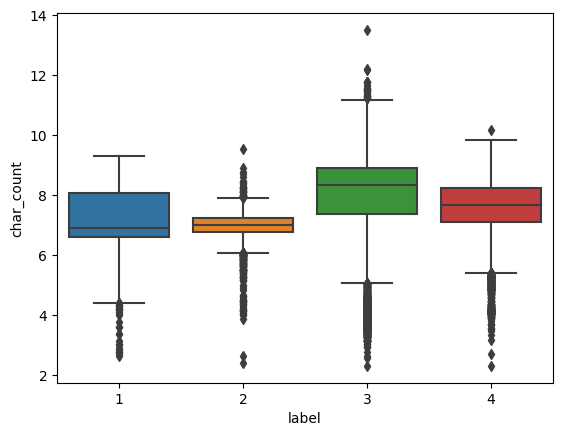

In [11]:
train['char_count'] = train['text'].apply(lambda x: np.log(len(x)))
sns.boxplot(x = train['label'] ,y = train['char_count'])

<Axes: xlabel='label', ylabel='sentence_count'>

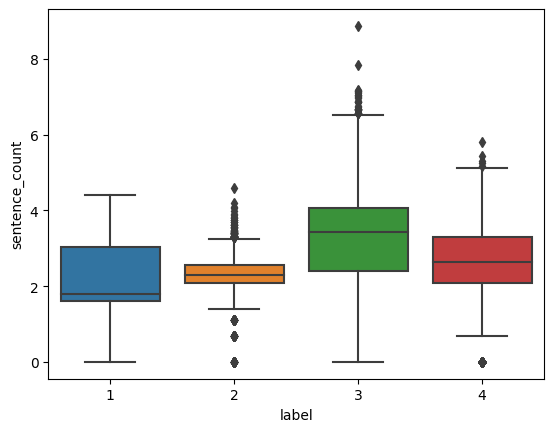

In [12]:
def count_sentence(text):
    return np.log(len(nltk.sent_tokenize(text)))

train['sentence_count'] = train['text'].apply(count_sentence)
sns.boxplot(x = train['label'] ,y = train['sentence_count']) 

<Axes: xlabel='label', ylabel='numerical_count'>

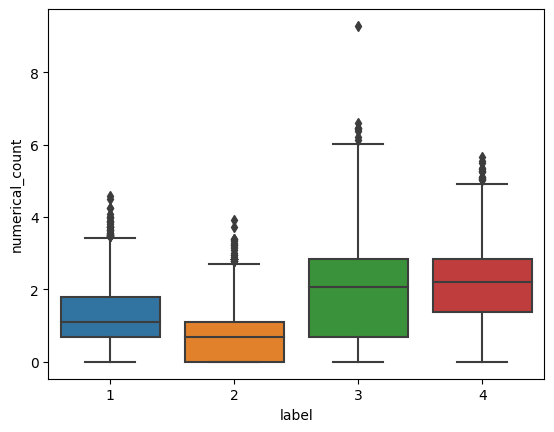

In [13]:
train['numerical_count'] = train['text'].apply(lambda x: np.log(len(re.findall(r'\d+', x))+1)) #some instances have 0 count, add 1 to prevent infinity when taking log
sns.boxplot(x = train['label'], y = "numerical_count", data = train)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<Axes: xlabel='label', ylabel='stopwords_count'>

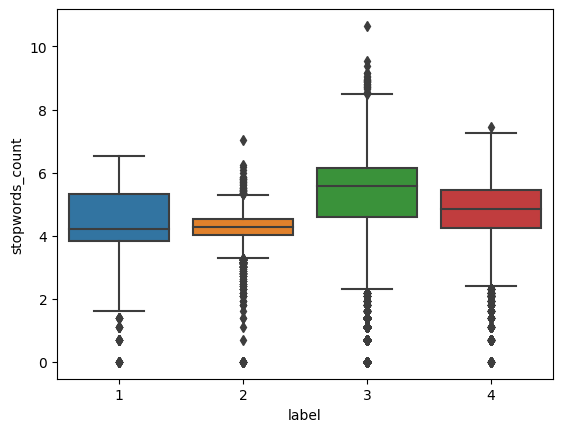

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return np.log(len(stopwords_x)+1)
train['stopwords_count'] = train['text'].apply(count_stopwords)
sns.boxplot(x='label', y="stopwords_count", data=train)

In [15]:
from gensim.utils import simple_preprocess
train = train[train['text'] != '']

# performs tokenization, lowercasing, removal of stop words & punctuation marks & numbers
train['text'] = train['text'].apply(simple_preprocess).apply(lambda x: ' '.join(x))

train_variables = train[['char_count',	'sentence_count',	'numerical_count',	'stopwords_count']].to_numpy()

In [16]:
train.head()

,label,text,char_count,sentence_count,numerical_count,stopwords_count
0,1,little less than decade ago hockey fans were b...,6.771936,1.945910,0.000000,3.871201
1,1,the writers of the hbo series the sopranos too...,6.572283,1.386294,0.693147,3.784190
2,1,despite claims from the tv news outlet to offe...,8.399085,3.332205,3.218876,5.407172
3,1,after receiving subpar service and experiencin...,8.272060,3.258097,2.302585,5.743003
4,1,after watching his beloved seattle mariners pr...,6.964136,1.945910,0.693147,4.174387


In [17]:
# apply to test set
test['char_count'] = test['text'].apply(lambda x: np.log(len(x)))
test['sentence_count'] = test['text'].apply(count_sentence)
test['text'] = test['text'].apply(simple_preprocess).apply(lambda x: ' '.join(x))
test['numerical_count'] = test['text'].apply(lambda x: np.log(len(re.findall(r'\d+', x))+1))
test['stopwords_count'] = test['text'].apply(count_stopwords)
test_variables = test[['char_count',	'sentence_count',	'numerical_count',	'stopwords_count']].to_numpy()

In [18]:
test.head()

,label,text,char_count,sentence_count,numerical_count,stopwords_count
0,1,when so many actors seem content to churn out ...,7.212294,2.772589,0.0,4.770685
1,1,in what football insiders are calling an unexp...,7.067320,2.484907,0.0,4.406719
2,1,in freak accident following game of the finals...,6.886532,1.791759,0.0,4.127134
3,1,north koreas official news agency announced to...,6.701960,1.609438,0.0,3.891820
4,1,the former alaska governor sarah palin would b...,7.021084,2.197225,0.0,4.204693


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(lowercase = True, 
                                   max_df = 0.8,  # any words that occur in more than 80% of the documents are removed
                                   min_df = 3, # any words that occur in less than 3 documents are removed
                                   max_features = 1000)  #consider top 1000 features among those
tfidf_train = tfidf_vectorizer.fit_transform(train['text'])

# apply to test
tfidf_test = tfidf_vectorizer.transform(test['text'])

## Preprocessing of word embeddings for traditional models

In [20]:
import os
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

In [22]:
glove_filename='glove.6B.200d.txt'
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
glove_path = os.path.abspath(os.path.join('.', glove_filename))

In [23]:
word2vec_output_file = glove_filename+'.word2vec'

glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

<ipython-input-23-f6bedfcf0033>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_path, word2vec_output_file)


In [24]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('queen')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = nltk.word_tokenize(sentence.lower())
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [25]:
word2vec_vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
word2vec_train = word2vec_vectorizer.fit_transform(train['text'])

Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 2 / 48652


In [26]:
# apply to test
word2vec_test = word2vec_vectorizer.fit_transform(test['text'])

Numer of samples with no words found: 0 / 3000


## Logistic regression

### Using all features (word embedding, tfidf, handcrafted features)

In [ ]:
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression

array_train = hstack((csr_matrix(train_variables),csr_matrix(word2vec_train), tfidf_train))
array_test = hstack((csr_matrix(test_variables),csr_matrix(word2vec_test), tfidf_test))

logreg = LogisticRegression(solver='liblinear',max_iter=500)

logreg.fit(array_train, train['label'])

LogisticRegression(max_iter=500, solver='liblinear')

In [ ]:
y_pred = logreg.predict(array_test)
y_test = test['label']
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7283333333333334

In [ ]:
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_f1

0.7226875527234484

In [ ]:
micro_f1 = f1_score(y_test, y_pred, average='micro')
micro_f1

0.7283333333333334

In [ ]:
confusion_matrix(y_test, y_pred)

array([[597,  82,  34,  37],
       [ 50, 397, 259,  44],
       [ 75,  15, 502, 158],
       [ 26,  12,  23, 689]])

<Axes: >

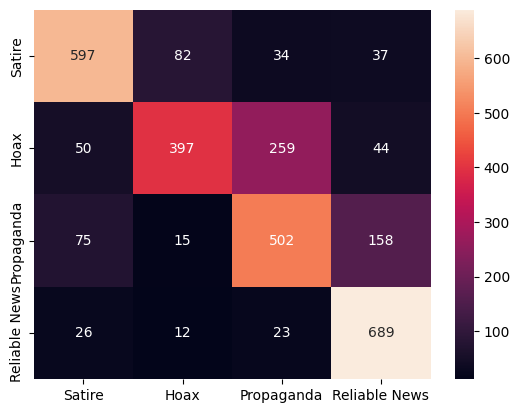

In [ ]:
labels = ["Satire", "Hoax", "Propaganda", "Reliable News"]

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels = labels, yticklabels = labels)

### Using only word embedding features

In [ ]:
array_train = csr_matrix(word2vec_train)
array_test = csr_matrix(word2vec_test)

logreg2 = LogisticRegression(solver='liblinear',max_iter=500)

logreg2.fit(array_train, train['label'])

LogisticRegression(max_iter=500, solver='liblinear')

In [ ]:
y_pred2 = logreg2.predict(array_test)
y_test = test['label']
accuracy = accuracy_score(y_test, y_pred2)
accuracy

0.6513333333333333

In [ ]:
macro_f1 = f1_score(y_test, y_pred2, average='macro')
macro_f1

0.6381622907837714

In [ ]:
micro_f1 = f1_score(y_test, y_pred2, average='micro')
micro_f1

0.6513333333333333

<Axes: >

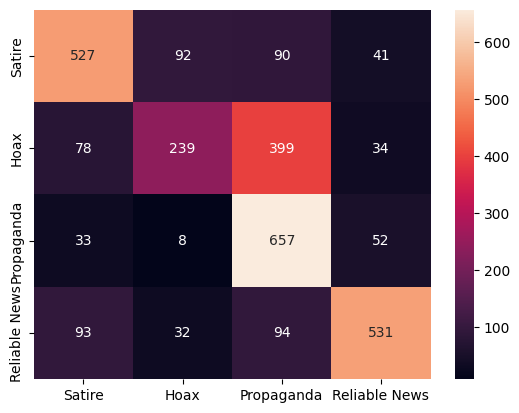

In [ ]:
labels = ["Satire", "Hoax", "Propaganda", "Reliable News"]

sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d', xticklabels = labels, yticklabels = labels)

## SVM

### Using linear kernel with SVD features

In [35]:
from sklearn import svm
from scipy.sparse import csr_matrix, hstack
from sklearn.decomposition import TruncatedSVD
array_train = hstack((csr_matrix(train_variables),csr_matrix(word2vec_train), tfidf_train))
array_test = hstack((csr_matrix(test_variables),csr_matrix(word2vec_test), tfidf_test))


pca = TruncatedSVD(n_components=200)
array_train_reduced = pca.fit_transform(array_train)
array_test_reduced = pca.transform(array_test)

In [36]:
array_train.shape

(48652, 1204)

In [37]:
svm1 = svm.SVC(kernel='linear')
svm1.fit(array_train_reduced, train['label'])


y_pred_svm1 = svm1.predict(array_test_reduced)
y_test = test['label']
accuracy = accuracy_score(y_test, y_pred_svm1)
accuracy

0.721

In [38]:
macro_f1 = f1_score(y_test, y_pred_svm1, average='macro')
macro_f1

0.7173587244310188

<Axes: >

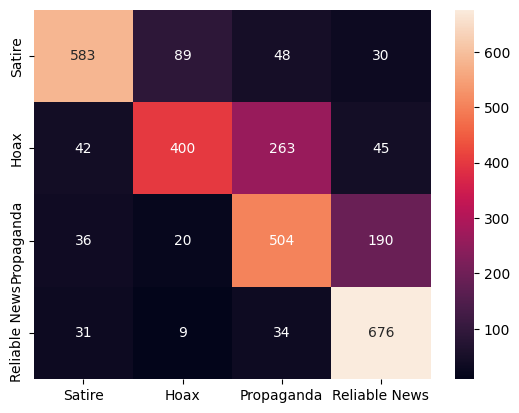

In [39]:
labels = ["Satire", "Hoax", "Propaganda", "Reliable News"]

sns.heatmap(confusion_matrix(y_test, y_pred_svm1), annot=True, fmt='d', xticklabels = labels, yticklabels = labels)

### Using rbf kernel with SVD features

In [ ]:
svm2 = svm.SVC(kernel='rbf')
svm2.fit(array_train_reduced, train['label'])

SVC()

In [ ]:
y_pred_svm2 = svm2.predict(array_test_reduced)
y_test = test['label']
accuracy = accuracy_score(y_test, y_pred_svm2)
accuracy

0.6843333333333333

In [ ]:
macro_f1 = f1_score(y_test, y_pred_svm2, average='macro')
macro_f1

0.6750972537966439

<Axes: >

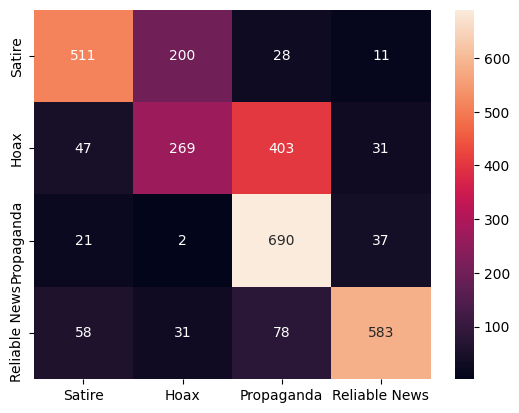

In [ ]:
labels = ["Satire", "Hoax", "Propaganda", "Reliable News"]

sns.heatmap(confusion_matrix(y_test, y_pred_svm2), annot=True, fmt='d', xticklabels = labels, yticklabels = labels)

In [ ]:
y_train_lin = svm1.predict(array_train_reduced)
y_train_rbf = svm2.predict(array_train_reduced)

In [ ]:
lin_train_f1 = f1_score(train['label'], y_train_lin, average='macro')
rbf_train_f1 = f1_score(train['label'], y_train_rbf, average='macro')

lin_train_f1, rbf_train_f1

(0.9492847376561906, 0.9321149788162147)

## Pre-processing of Word embedding for LSTM & BiLSTM

In [ ]:
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 10000
max_length = 500

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['text'])

# apply to train set
train_tokenized = tokenizer.texts_to_sequences(train['text'])
train_tokenized = pad_sequences(train_tokenized, maxlen = max_length, padding='post')
y_train = train['label'].values

# apply to test set
test_tokenized = tokenizer.texts_to_sequences(test['text'])
test_tokenized = pad_sequences(test_tokenized, maxlen = max_length, padding='post')
y_test = test['label'].values

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open('glove.6B.200d.txt'))

In [ ]:
# get embeddings
embeddings = np.stack(embeddings_index.values())
embeddings_mean = embeddings.mean()
embeddings_std = embeddings.std()
word_index = tokenizer.word_index

# get no. of words
num_words = min(max_features, len(word_index))

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
embeddings_size = embeddings.shape[1]

# create embedding matrix
embedding_matrix = np.random.normal(embeddings_mean, embeddings_std, (num_words, embeddings_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

## LSTM

In [ ]:
#  embedding matrix        other variables 
#           |             (i.e. sentence count, char count, numerical count, stopwords count, tfidf features)
#           |                   |
#           |                   |
#           |                   |
#       embedding layer         |
#           |                   |
#           |                   |
#         LSTM                  | 
#            \                 /        
#              \              / 
#               dense layers
#                    | 
#                    | 
#               output_layer 

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from scipy.sparse import csr_matrix, hstack

In [ ]:
def loss_acc_plots(history):
  train_accuracy = history.history['accuracy']
  train_loss = history.history['loss']
  test_accuracy = history.history['val_accuracy']
  test_loss = history.history['val_loss']
  train_accuracy = history.history['accuracy']
  train_loss = history.history['loss']

  num_epochs = list(range(len(train_accuracy)))
  plt.plot(num_epochs, train_accuracy, label = 'Train Accuracy')
  plt.plot(num_epochs, test_accuracy, label = 'Test Accuracy')
  plt.title('Accuracy over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(num_epochs, train_loss, label = 'Train Loss')
  plt.plot(num_epochs, test_loss, label = 'Test Loss')
  plt.title('Loss over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

### Using embedding features and other features excluding tfidf features

#### 1 LSTM layer

In [ ]:
# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = LSTM(units = 128)(embedding_layer)

concat_layer = concatenate([lstm1, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_lstm = Model(inputs=[input_text, input_variables], outputs=output_layer)

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_lstm = model_lstm.fit(x=[train_tokenized, train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 28s 28ms/step - loss: 0.9691 - accuracy: 0.5932 - val_loss: 1.6483 - val_accuracy: 0.1295 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 18s 26ms/step - loss: 0.7435 - accuracy: 0.7293 - val_loss: 1.4103 - val_accuracy: 0.3352 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 18s 26ms/step - loss: 0.5261 - accuracy: 0.8165 - val_loss: 1.1485 - val_accuracy: 0.5138 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 18s 26ms/step - loss: 0.3406 - accuracy: 0.8868 - val_loss: 0.8112 - val_accuracy: 0.7125 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 17s 25ms/step - loss: 0.2514 - accuracy: 0.9174 - val_loss: 0.6135 - val_accuracy: 0.7813 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 18s 26ms/step - loss: 0.1986 - accuracy: 0.9351 - val_loss: 0.4167 - val_accuracy: 0.8354 - lr: 3.0000e-04
Epoch 7/50
685/685 [==============

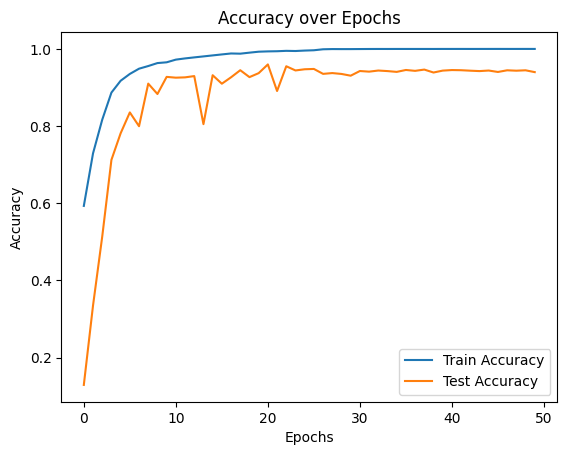

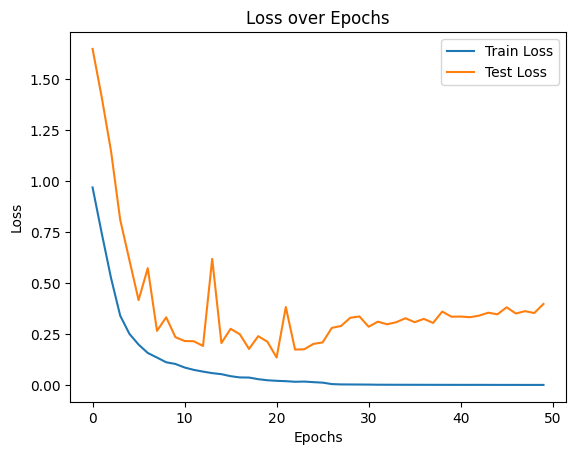

In [ ]:
loss_acc_plots(history_lstm)

In [ ]:
y_preds_lstm = model_lstm.predict([test_tokenized, test_variables])
y_preds_lstm = y_preds_lstm.argmax(axis=1)
y_preds_lstm = y_preds_lstm + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_lstm))
print('Test set f1-score: ', f1_score(y_test, y_preds_lstm,average='macro'))

94/94 [==============================] - 1s 9ms/step
Test set accuracy:  0.644
Test set f1-score:  0.624640072285872


<Axes: >

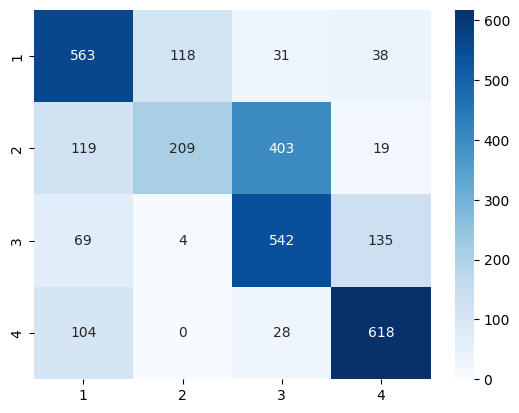

In [ ]:
cm = confusion_matrix(y_test, y_preds_lstm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

#### 2 LSTM layers

In [ ]:
# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = LSTM(units = 128, return_sequences=True)(embedding_layer)
lstm2 = LSTM(units = 128)(lstm1)

concat_layer = concatenate([lstm2, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_lstm2 = Model(inputs=[input_text, input_variables], outputs=output_layer)

model_lstm2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_lstm2 = model_lstm2.fit(x=[train_tokenized, train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 43s 49ms/step - loss: 0.9219 - accuracy: 0.6120 - val_loss: 1.6017 - val_accuracy: 0.1827 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 33s 49ms/step - loss: 0.7651 - accuracy: 0.7005 - val_loss: 1.0869 - val_accuracy: 0.4778 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 33s 48ms/step - loss: 0.7157 - accuracy: 0.7377 - val_loss: 1.0695 - val_accuracy: 0.6130 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 33s 48ms/step - loss: 0.5566 - accuracy: 0.8014 - val_loss: 1.1324 - val_accuracy: 0.5162 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 32s 46ms/step - loss: 0.3652 - accuracy: 0.8721 - val_loss: 0.7354 - val_accuracy: 0.7320 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 33s 48ms/step - loss: 0.2773 - accuracy: 0.9096 - val_loss: 0.6759 - val_accuracy: 0.7600 - lr: 3.0000e-04
Epoch 7/50
685/685 [==============

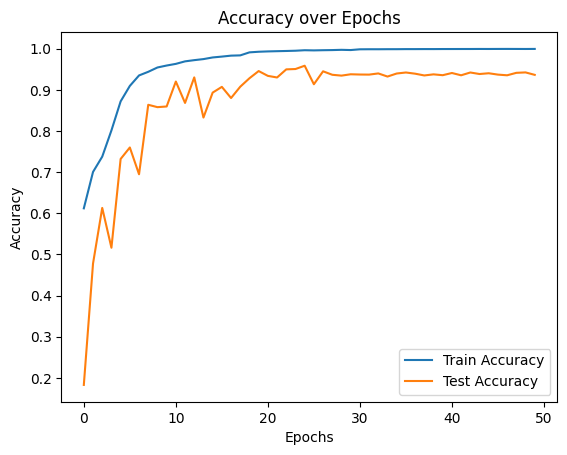

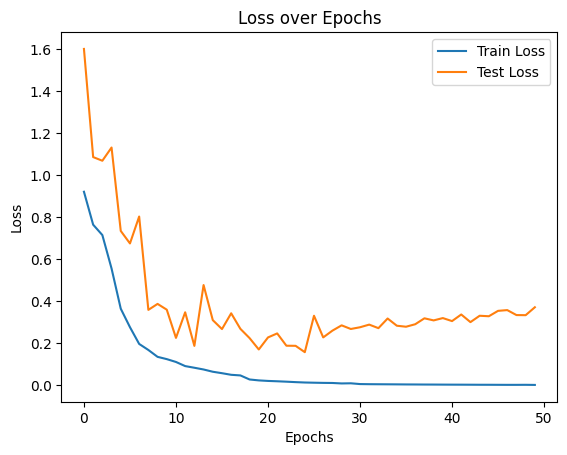

In [ ]:
loss_acc_plots(history_lstm2)

In [ ]:
y_preds_lstm2= model_lstm2.predict([test_tokenized, test_variables])
y_preds_lstm2 = y_preds_lstm2.argmax(axis=1)
y_preds_lstm2 = y_preds_lstm2 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_lstm2))
print('Test set f1-score: ', f1_score(y_test, y_preds_lstm2,average='macro'))

94/94 [==============================] - 2s 15ms/step
Test set accuracy:  0.6766666666666666
Test set f1-score:  0.6643413422934364


<Axes: >

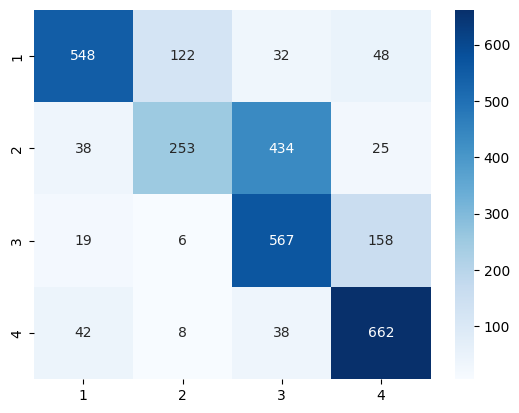

In [ ]:
cm = confusion_matrix(y_test, y_preds_lstm2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

### Using only word embedding features 

#### 2 LSTM layers

In [ ]:
# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = LSTM(units = 128, return_sequences=True)(embedding_layer)
lstm2 = LSTM(units = 128)(lstm1)

output_layer = Dense(units=4, activation='softmax')(lstm2)

model_lstm3 = Model(inputs=input_text, outputs=output_layer)

model_lstm3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_lstm3 = model_lstm3.fit(x=train_tokenized, y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 36s 48ms/step - loss: 1.0405 - accuracy: 0.5260 - val_loss: 1.8990 - val_accuracy: 0.1025 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 32s 46ms/step - loss: 0.9771 - accuracy: 0.5572 - val_loss: 1.7323 - val_accuracy: 0.1424 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 33s 49ms/step - loss: 0.8741 - accuracy: 0.6384 - val_loss: 1.6458 - val_accuracy: 0.1480 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 33s 48ms/step - loss: 0.7967 - accuracy: 0.6735 - val_loss: 1.5104 - val_accuracy: 0.2127 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 33s 48ms/step - loss: 0.7680 - accuracy: 0.6831 - val_loss: 1.5796 - val_accuracy: 0.2826 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 33s 48ms/step - loss: 0.5574 - accuracy: 0.7832 - val_loss: 0.8160 - val_accuracy: 0.6739 - lr: 3.0000e-04
Epoch 7/50
685/685 [==============

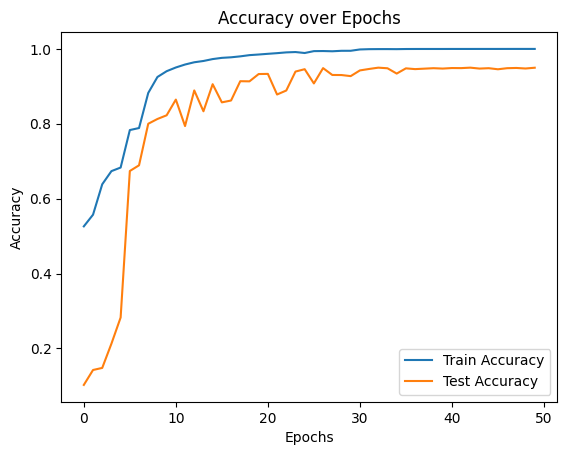

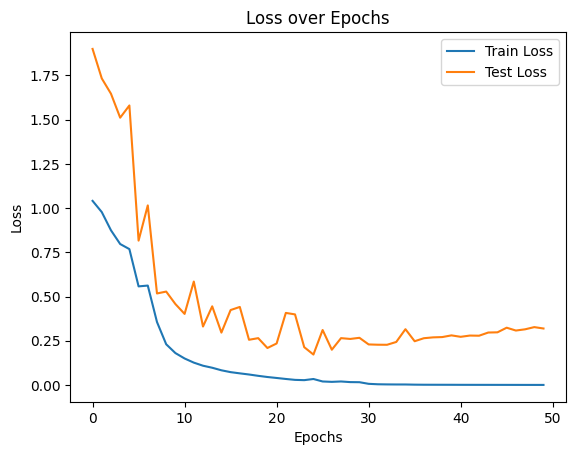

In [ ]:
loss_acc_plots(history_lstm3)

In [ ]:
y_preds_lstm3= model_lstm3.predict(test_tokenized)
y_preds_lstm3 = y_preds_lstm3.argmax(axis=1)
y_preds_lstm3 = y_preds_lstm3 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_lstm3))
print('Test set f1-score: ', f1_score(y_test, y_preds_lstm3,average='macro'))

94/94 [==============================] - 2s 14ms/step
Test set accuracy:  0.6793333333333333
Test set f1-score:  0.6626461356749016


### Using all features

#### 2 LSTM layers

In [ ]:
all_other_train_variables = hstack((csr_matrix(train_variables), tfidf_train)).todense()
all_other_test_variables = hstack((csr_matrix(test_variables), tfidf_test)).todense()

# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(all_other_train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = LSTM(units = 128, return_sequences=True)(embedding_layer)
lstm2 = LSTM(units = 128)(lstm1)

concat_layer = concatenate([lstm2, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_lstm4 = Model(inputs=[input_text, input_variables], outputs=output_layer)

model_lstm4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_lstm4 = model_lstm4.fit(x=[train_tokenized, all_other_train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 42s 48ms/step - loss: 0.7620 - accuracy: 0.7342 - val_loss: 1.3289 - val_accuracy: 0.4112 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 33s 48ms/step - loss: 0.3591 - accuracy: 0.9014 - val_loss: 0.6097 - val_accuracy: 0.7711 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 32s 46ms/step - loss: 0.2199 - accuracy: 0.9349 - val_loss: 0.4237 - val_accuracy: 0.8409 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 32s 46ms/step - loss: 0.1806 - accuracy: 0.9473 - val_loss: 0.4577 - val_accuracy: 0.8288 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 33s 48ms/step - loss: 0.1430 - accuracy: 0.9572 - val_loss: 0.3485 - val_accuracy: 0.8707 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 32s 46ms/step - loss: 0.1122 - accuracy: 0.9660 - val_loss: 0.2162 - val_accuracy: 0.9219 - lr: 3.0000e-04
Epoch 7/50
685/685 [==============

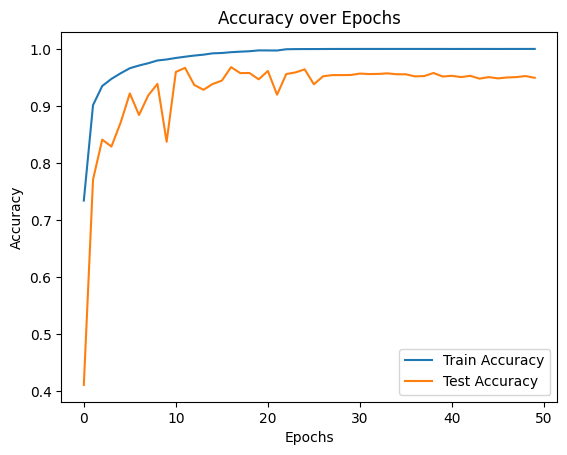

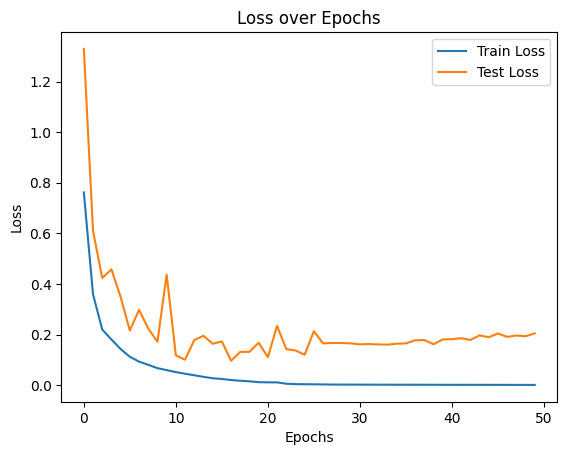

In [ ]:
loss_acc_plots(history_lstm4)

In [ ]:
y_preds_lstm4= model_lstm4.predict([test_tokenized, all_other_test_variables])
y_preds_lstm4 = y_preds_lstm4.argmax(axis=1)
y_preds_lstm4 = y_preds_lstm4 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_lstm4))
print('Test set f1-score: ', f1_score(y_test, y_preds_lstm4,average='macro'))

94/94 [==============================] - 3s 21ms/step
Test set accuracy:  0.693
Test set f1-score:  0.6837744426443642


<Axes: >

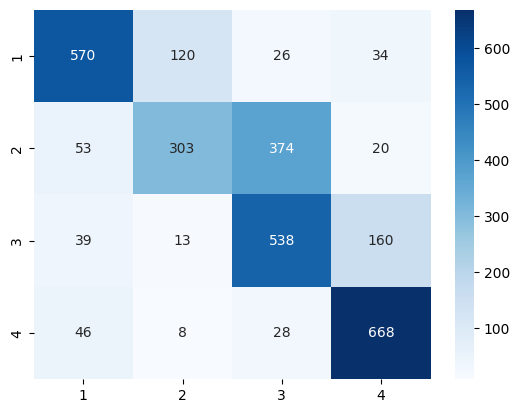

In [ ]:
cm = confusion_matrix(y_test, y_preds_lstm4)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

## Bidirectional LSTM

### Using embedding features and other features excluding tfidf features

#### 2 BiLSTM layers

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate,LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# bidirectional lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = Bidirectional(LSTM(units = 128, return_sequences=True))(embedding_layer)
lstm2 = Bidirectional(LSTM(units = 64))(lstm1)

concat_layer = concatenate([lstm2, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_bilstm = Model(inputs=[input_text, input_variables], outputs=output_layer)


model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_bilstm = model_bilstm.fit(x=[train_tokenized, train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 68s 89ms/step - loss: 0.4467 - accuracy: 0.8407 - val_loss: 0.8506 - val_accuracy: 0.6862 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 59s 86ms/step - loss: 0.2587 - accuracy: 0.9098 - val_loss: 0.9506 - val_accuracy: 0.6443 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 59s 86ms/step - loss: 0.1811 - accuracy: 0.9384 - val_loss: 0.5352 - val_accuracy: 0.7904 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 59s 86ms/step - loss: 0.1349 - accuracy: 0.9542 - val_loss: 0.3284 - val_accuracy: 0.8771 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 59s 87ms/step - loss: 0.1108 - accuracy: 0.9624 - val_loss: 0.5447 - val_accuracy: 0.7959 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 59s 87ms/step - loss: 0.0963 - accuracy: 0.9675 - val_loss: 0.3412 - val_accuracy: 0.8703 - lr: 3.0000e-04
Epoch 7/50
685/685 [==============

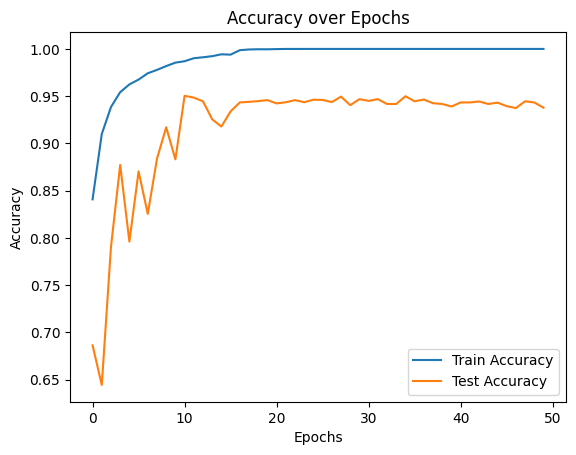

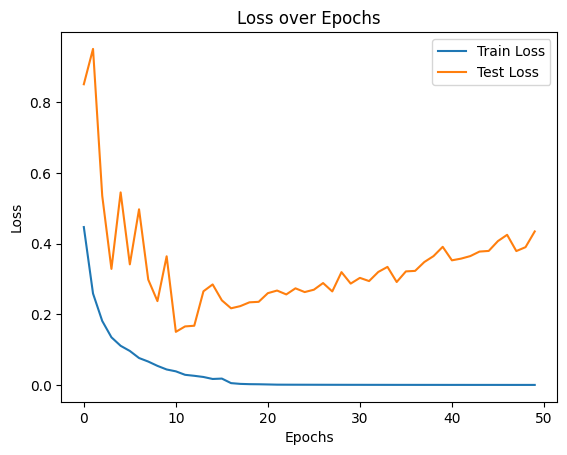

In [ ]:
loss_acc_plots(history_bilstm)

In [ ]:
y_preds_bilstm= model_bilstm.predict([test_tokenized, test_variables])
y_preds_bilstm = y_preds_bilstm.argmax(axis=1)
y_preds_bilstm = y_preds_bilstm + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_bilstm))
print('Test set f1-score: ', f1_score(y_test, y_preds_bilstm,average='macro'))

94/94 [==============================] - 4s 28ms/step
Test set accuracy:  0.6893333333333334
Test set f1-score:  0.6749464043958147


<Axes: >

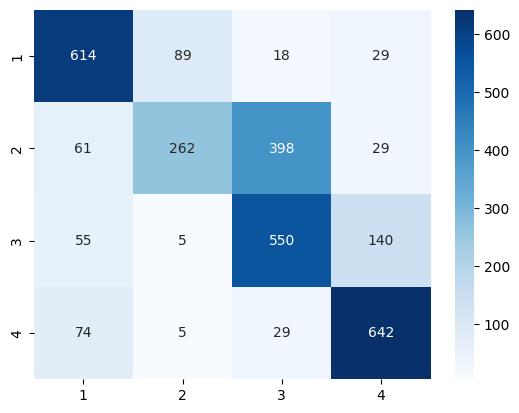

In [ ]:
cm = confusion_matrix(y_test, y_preds_bilstm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

#### 3 BiLSTM layers

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate,LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = Bidirectional(LSTM(units = 128, return_sequences=True))(embedding_layer)
lstm2 = Bidirectional(LSTM(units = 128, return_sequences=True))(lstm1)
lstm3 = Bidirectional(LSTM(units = 64))(lstm2)

concat_layer = concatenate([lstm3, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_bilstm2 = Model(inputs=[input_text, input_variables], outputs=output_layer)


model_bilstm2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_bilstm2 = model_bilstm2.fit(x=[train_tokenized, train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 118s 145ms/step - loss: 0.4860 - accuracy: 0.8246 - val_loss: 0.9297 - val_accuracy: 0.6136 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 96s 140ms/step - loss: 0.2711 - accuracy: 0.9074 - val_loss: 0.5242 - val_accuracy: 0.8074 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 96s 140ms/step - loss: 0.1993 - accuracy: 0.9314 - val_loss: 0.5944 - val_accuracy: 0.7945 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 97s 142ms/step - loss: 0.1982 - accuracy: 0.9314 - val_loss: 0.4082 - val_accuracy: 0.8261 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 96s 141ms/step - loss: 0.1630 - accuracy: 0.9431 - val_loss: 0.5098 - val_accuracy: 0.7949 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 97s 142ms/step - loss: 0.1286 - accuracy: 0.9565 - val_loss: 0.3273 - val_accuracy: 0.8625 - lr: 3.0000e-04
Epoch 7/50
685/685 [=======

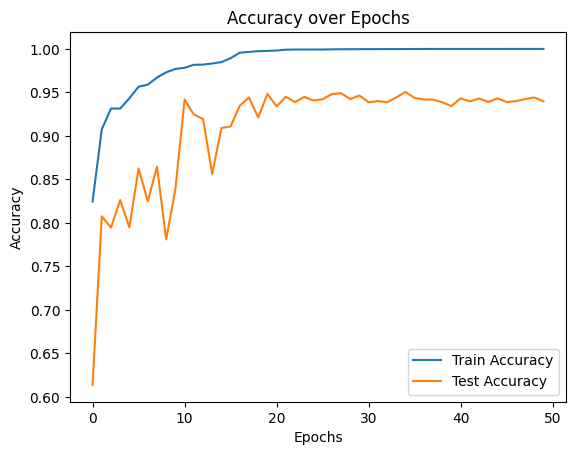

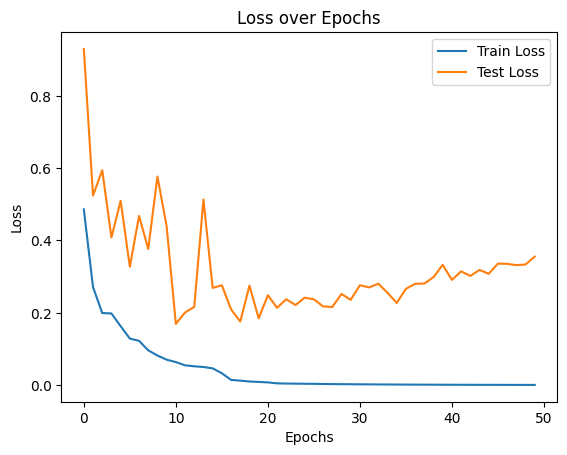

In [ ]:
loss_acc_plots(history_bilstm2)

In [ ]:
y_preds_bilstm2 = model_bilstm2.predict([test_tokenized, test_variables])
y_preds_bilstm2 = y_preds_bilstm2.argmax(axis=1)
y_preds_bilstm2 = y_preds_bilstm2 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_bilstm2))
print('Test set f1-score: ', f1_score(y_test, y_preds_bilstm2,average='macro'))

94/94 [==============================] - 4s 41ms/step
Test set accuracy:  0.7006666666666667
Test set f1-score:  0.6912330208159098


<Axes: >

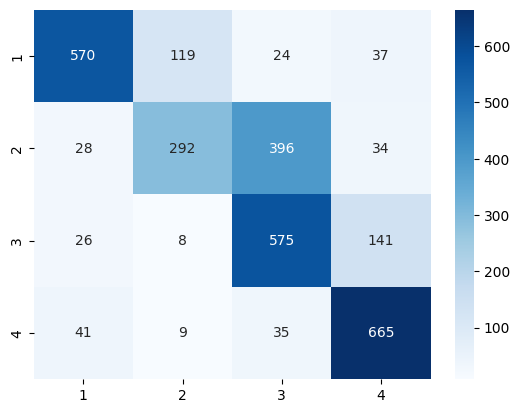

In [ ]:
cm = confusion_matrix(y_test, y_preds_bilstm2)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

### Using only word embedding features

#### 3 BiLSTM layers

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate,LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# bilstm model using only word embedding features
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = Bidirectional(LSTM(units = 128, return_sequences=True))(embedding_layer)
lstm2 = Bidirectional(LSTM(units = 128, return_sequences=True))(lstm1)
lstm3 = Bidirectional(LSTM(units = 64))(lstm2)

dense1 = Dense(units=42, activation='relu')(lstm3)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_bilstm3 = Model(inputs=input_text, outputs=output_layer)


model_bilstm3.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_bilstm3 = model_bilstm3.fit(x=train_tokenized, y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 109s 143ms/step - loss: 0.4359 - accuracy: 0.8450 - val_loss: 0.7965 - val_accuracy: 0.7088 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 96s 140ms/step - loss: 0.2427 - accuracy: 0.9169 - val_loss: 0.6420 - val_accuracy: 0.6591 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 96s 140ms/step - loss: 0.1963 - accuracy: 0.9331 - val_loss: 0.6297 - val_accuracy: 0.7474 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 96s 140ms/step - loss: 0.1573 - accuracy: 0.9468 - val_loss: 0.5289 - val_accuracy: 0.8035 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 95s 138ms/step - loss: 0.1319 - accuracy: 0.9548 - val_loss: 0.4346 - val_accuracy: 0.8533 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 95s 139ms/step - loss: 0.1277 - accuracy: 0.9559 - val_loss: 0.4690 - val_accuracy: 0.7998 - lr: 3.0000e-04
Epoch 7/50
685/685 [=======

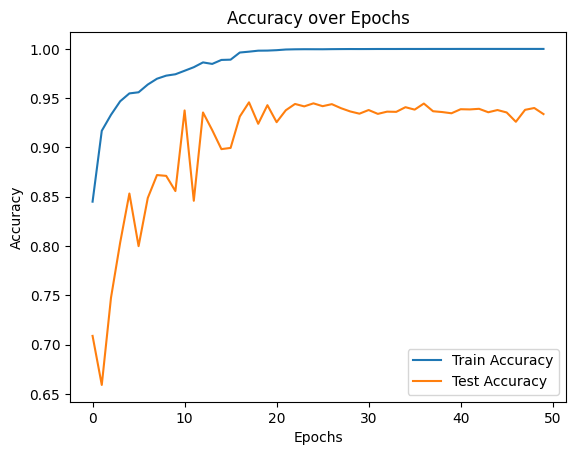

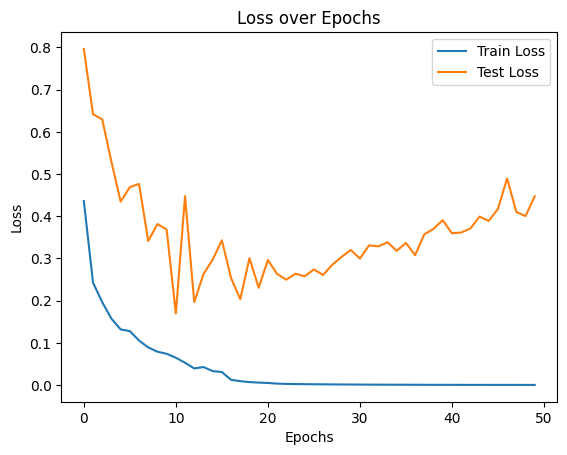

In [ ]:
loss_acc_plots(history_bilstm3)

In [ ]:
y_preds_bilstm3 = model_bilstm3.predict(test_tokenized)
y_preds_bilstm3 = y_preds_bilstm3.argmax(axis=1)
y_preds_bilstm3 = y_preds_bilstm3 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_bilstm3))
print('Test set f1-score: ', f1_score(y_test, y_preds_bilstm3,average='macro'))

94/94 [==============================] - 4s 40ms/step
Test set accuracy:  0.6853333333333333
Test set f1-score:  0.6734703363673511


<Axes: >

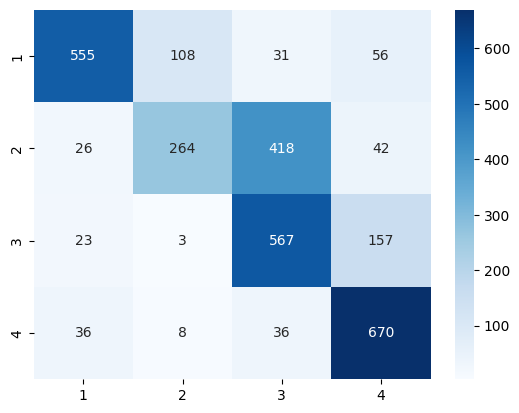

In [ ]:
cm = confusion_matrix(y_test, y_preds_bilstm3)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])

### Using all features

#### 3 BiLSTM layers

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate,LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

all_other_train_variables = hstack((csr_matrix(train_variables), tfidf_train)).todense()
all_other_test_variables = hstack((csr_matrix(test_variables), tfidf_test)).todense()

# lstm model
input_text = Input(shape=(train_tokenized.shape[1]))
input_variables = Input(shape=(all_other_train_variables.shape[1]))

# embedding layer
embedding_layer = Embedding(max_features,  # num distinct words
                    output_dim = embeddings_size,
                    weights = [embedding_matrix],
                    input_length = max_length, # length of each vector
                    trainable = False)(input_text)

lstm1 = Bidirectional(LSTM(units = 128, return_sequences=True))(embedding_layer)
lstm2 = Bidirectional(LSTM(units = 128, return_sequences=True))(lstm1)
lstm3 = Bidirectional(LSTM(units = 64))(lstm2)

concat_layer = concatenate([lstm3, input_variables])

dense1 = Dense(units=42, activation='relu')(concat_layer)
output_layer = Dense(units=4, activation='softmax')(dense1)

model_bilstm4 = Model(inputs=[input_text, input_variables], outputs=output_layer)


model_bilstm4.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate = 3e-4), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00001)
history_bilstm4 = model_bilstm4.fit(x=[train_tokenized, all_other_train_variables], y=y_train-1, epochs = 50, batch_size = 64, validation_split = 0.1, shuffle=True, callbacks = [reduce_lr])


Epoch 1/50
685/685 [==============================] - 108s 143ms/step - loss: 0.5031 - accuracy: 0.8099 - val_loss: 0.5349 - val_accuracy: 0.8033 - lr: 3.0000e-04
Epoch 2/50
685/685 [==============================] - 96s 140ms/step - loss: 0.2061 - accuracy: 0.9302 - val_loss: 0.6193 - val_accuracy: 0.7314 - lr: 3.0000e-04
Epoch 3/50
685/685 [==============================] - 96s 140ms/step - loss: 0.1495 - accuracy: 0.9513 - val_loss: 0.4390 - val_accuracy: 0.8136 - lr: 3.0000e-04
Epoch 4/50
685/685 [==============================] - 97s 142ms/step - loss: 0.1204 - accuracy: 0.9606 - val_loss: 0.3691 - val_accuracy: 0.8500 - lr: 3.0000e-04
Epoch 5/50
685/685 [==============================] - 96s 140ms/step - loss: 0.0889 - accuracy: 0.9716 - val_loss: 0.3102 - val_accuracy: 0.8804 - lr: 3.0000e-04
Epoch 6/50
685/685 [==============================] - 96s 140ms/step - loss: 0.0724 - accuracy: 0.9768 - val_loss: 0.1569 - val_accuracy: 0.9418 - lr: 3.0000e-04
Epoch 7/50
685/685 [=======

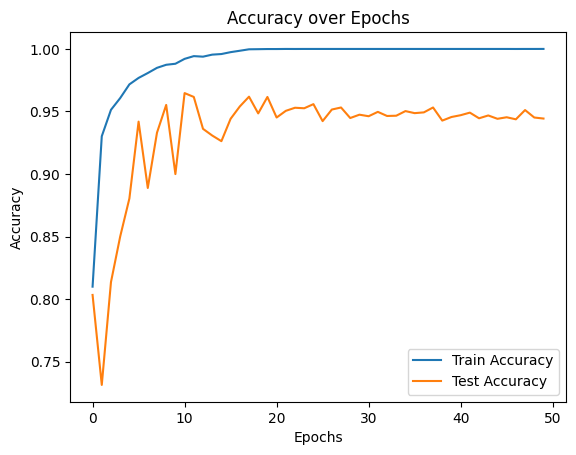

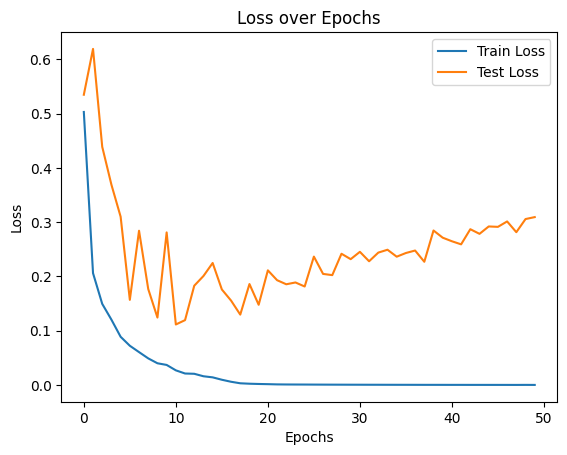

In [ ]:
loss_acc_plots(history_bilstm4)

In [ ]:
y_preds_bilstm4 = model_bilstm4.predict([test_tokenized, all_other_test_variables])
y_preds_bilstm4 = y_preds_bilstm4.argmax(axis=1)
y_preds_bilstm4 = y_preds_bilstm4 + 1 #convert labels back to between 1 and 4
print('Test set accuracy: ', accuracy_score(y_test, y_preds_bilstm4))
print('Test set f1-score: ', f1_score(y_test, y_preds_bilstm4,average='macro'))

94/94 [==============================] - 7s 40ms/step
Test set accuracy:  0.707
Test set f1-score:  0.6956591872971662


<Axes: >

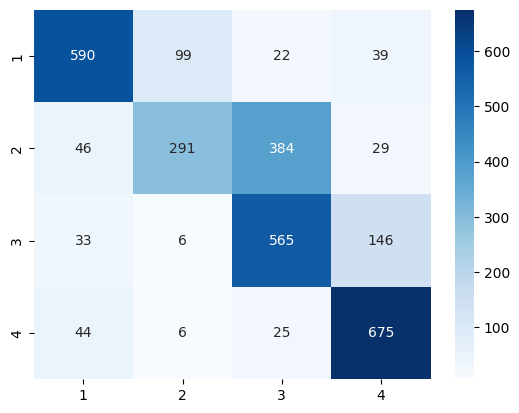

In [ ]:
cm = confusion_matrix(y_test, y_preds_bilstm4)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[1,2,3,4], yticklabels=[1,2,3,4])